In [13]:
import numpy as np
import keras
import random
from keras.utils import to_categorical
import os
import matplotlib.pyplot as plt
import random
import cv2
from scipy import ndimage
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import datetime
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [14]:
path = "D:/downloads/train/"
path_seis = os.path.join(path,'seis')
path_fault = os.path.join(path,'fault')
validation_path = "D:/downloads/validation/"
validation_seis = os.path.join(validation_path,'seis')
validation_fault = os.path.join(validation_path,'fault')

In [15]:
def get_data(seis_path, fault_path):
    seis_names = os.listdir(seis_path)
    fault_names = os.listdir(fault_path)
    X = []
    Y = []
    for i in range(len(seis_names)):
        seis_cube = np.fromfile(os.path.join(seis_path, seis_names[i]),dtype=np.single)
        faults = np.fromfile(os.path.join(fault_path, fault_names[i]),dtype=np.single)
        dim = (128,128,128)
        seis_cube = np.reshape(seis_cube, dim)
        fault = np.reshape(faults, dim)
        seis_m = np.mean(seis_cube)
        seis_sigma = np.std(seis_cube)
        seis_cube_norm = (seis_cube-seis_m)/seis_sigma
        x = np.reshape(seis_cube_norm,(1,128,128,128,1))
        y =  np.reshape(fault,(1,128,128,128,1))
        #seis_cube_norm = np.transpose(seis_cube_norm)
        #fault = np.transpose(fault)

        for k in range(128):
            X.append(np.transpose(x[0,k,:,:,0]))
            X.append(np.transpose(x[0,:,k,:,0]))
            Y.append(np.transpose(y[0,k,:,:,0]))
            Y.append(np.transpose(y[0,:,k,:,0]))
    X = np.array(X)
    Y = np.array(Y)
    X = X/255.0
    return X,Y
    

In [16]:
dataset, target = get_data(path_seis, path_fault)
print(dataset.shape)
validation_x, validation_y = get_data(validation_seis, validation_fault)
print(validation_x.shape)

(51200, 128, 128)
(5120, 128, 128)


In [17]:
x_train, x_test, y_train, y_test = train_test_split(dataset, target, random_state=4)
print(x_train.shape, x_test.shape)

(38400, 128, 128) (12800, 128, 128)


# Data visualisation

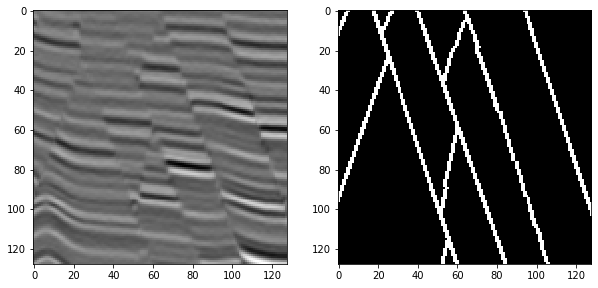

In [18]:
#seis_cube = np.fromfile(os.path.join(path_seis, seis_names[0]),dtype=np.single)
#faults = np.fromfile(os.path.join(path_fault, fault_names[0]),dtype=np.single)
seis_cube = x_train[10]
faults = y_train[10]

# dim = (128,128,128)
# seis_cube = np.reshape(seis_cube, dim)
# fault = np.reshape(faults, dim)
# seis_m = np.mean(seis_cube)
# seis_sigma = np.std(seis_cube)
# seis_cube_norm = (seis_cube-seis_m)/seis_sigma
# x = np.reshape(seis_cube_norm,(1,128,128,128,1))
# #y = np.transpose(fault)
# y = np.reshape(fault,(1,128,128,128,1))
fig = plt.figure(figsize=(10,10))
#inline slice
k1 = 5
plt.subplot(1, 2, 1)
imgplot1 = plt.imshow(seis_cube,interpolation='nearest',aspect=1,cmap=plt.cm.gray)
plt.subplot(1, 2, 2)
imgplot2 = plt.imshow(faults,interpolation='nearest',aspect=1,cmap=plt.cm.gray)
#xline slice
# k2 = 0
# plt.subplot(1, 3, 2)
# imgplot1 = plt.imshow(np.transpose(x[0,:,k2,:,0]),cmap=plt.cm.gray,interpolation='nearest',aspect=1)


# #time slice
# k3 = 60
# plt.subplot(1, 3, 3)
# imgplot1 = plt.imshow(np.transpose(x[0,:,:,k3,0]),cmap=plt.cm.gray,interpolation='nearest',aspect=1)

In [19]:
def rotation(pair,angle):
    #print("rotation at angle ",angle)
    pair[0] = ndimage.rotate(pair[0], angle) 
    pair[1] = ndimage.rotate(pair[1], angle)
    pair[0] = cv2.resize(pair[0],(128,128))
    pair[1] = cv2.resize(pair[1],(128,128))
    #pair[1] = pair[1].reshape((128,128))
    return pair

def blur(pair):
    kernel = (random.randint(1,10), random.randint(1,5))
    #print('Blurring with kernel sizes: ', kernel)
    pair[0] = cv2.blur(pair[0], kernel)
    pair[1] = cv2.blur(pair[1], kernel)
    pair[0] = cv2.resize(pair[0],(128,128))
    pair[1] = cv2.resize(pair[1],(128,128))
    return pair

def flip(pair):
    flip = random.randint(-1,1)
    #print('Reflection at direction', flip)
    pair[0] = cv2.flip(pair[0], flip)
    pair[1] = cv2.flip(pair[1], flip)
    pair[0] = cv2.resize(pair[0],(128,128))
    pair[1] = cv2.resize(pair[1],(128,128))
    return pair
    
def augmentations(pair, type_of_augmentation):
    cases = {
        '1': lambda pair: rotation(pair, random.randrange(0,360)),
        '2': lambda pair: blur(pair),
        '3': lambda pair: flip(pair)
    }
    result = cases[str(type_of_augmentation)]
    return result(pair)



In [20]:
def augmentation(quantity, X, Y):
    pairs = [[X[i], Y[i]] for i in range(quantity)]
    x_augmented = pairs
    for i, pair in enumerate(pairs):
        x_augmented[i] = augmentations(pair, random.randint(1,3))
    x_augmented = np.array(x_augmented)
    return x_augmented

In [21]:
x_augmented = augmentation(250, x_train, y_train)
# np.append(x_train_augmented,x_train)   
# np.append(y_train,y_train)
#print(X.shape, x_augmented[0].shape)
x_train = np.append(x_train, x_augmented[:,0],axis=0)
y_train = np.append(y_train, x_augmented[:,1],axis=0)

In [22]:
def unet(input_size = (None,None,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(16, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1)

    conv2 = Conv2D(32, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2)

    conv3 = Conv2D(64, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2,2))(conv3)

    conv4 = Conv2D(128, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = concatenate([UpSampling2D(size=(2,2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(up5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2,2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(32, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(32, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2,2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(16, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(16, 3, activation='relu', padding='same')(conv7)

    conv8 = Conv2D(1, 1, activation='sigmoid')(conv7)

    model = Model(inputs=[inputs], outputs=[conv8])
    model.summary()
    #model.compile(optimizer = Adam(lr = 1e-4), 
    #    loss = cross_entropy_balanced, metrics = ['accuracy'])
    return model

In [23]:
model = unet(input_size=(None, None, 1))
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', 
            metrics=['accuracy'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 1 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 1 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

# Model fit

In [24]:
log_dir = "logs/2dseg/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(x = x_train,y=y_train, epochs=5, batch_size=64, validation_data = (validation_x, validation_y),
        callbacks=[tensorboard_callback] )
model.save_weights('weights.h5')

Epoch 1/5
  1/604 [..............................] - ETA: 13s - loss: 0.6932 - accuracy: 0.1568WARNING:tensorflow:From C:\Users\Sizov\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
604/604 [==============================] - 2790s 5s/step - loss: 0.2840 - accuracy: 0.9272 - val_loss: 0.2596 - val_accuracy: 0.9277
Epoch 2/5
604/604 [==============================] - 2639s 4s/step - loss: 0.2527 - accuracy: 0.9285 - val_loss: 0.2545 - val_accuracy: 0.9277
Epoch 3/5
604/604 [==============================] - 2885s 5s/step - loss: 0.2083 - accuracy: 0.9315 - val_loss: 0.1827 - val_accuracy: 0.9369
Epoch 4/5
604/604 [==============================] - 3847s 6s/step - loss: 0.1668 - accuracy: 0.9410 - val_loss: 0.1674 - val_accuracy: 0.9422
Epoch 5/5
604/604 [==============================] - 2523s 4s

In [37]:
print(x_test.shape)
x_test[0].reshape(128,128,1)
y = model.predict(x_test)
print(y[0].shape)

(12800, 128, 128)
(128, 128, 1)


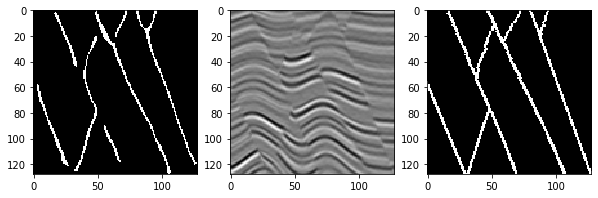

In [70]:
mask = y[900].reshape(128,128)
kernel = np.ones((2,2), np.uint8)
mask = cv2.erode(mask, kernel, iterations = 1)
mask = np.around((mask) * 255).astype(np.uint8)
nothing, mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
imgplot1 = plt.imshow(mask,interpolation='nearest',aspect=1,cmap=plt.cm.gray)
plt.subplot(1,3,2)
imgplot2 = plt.imshow(x_test[900],interpolation='nearest',aspect=1,cmap=plt.cm.gray)
mask_test = y_test[900].reshape(128,128)
plt.subplot(1,3,3)
imgplot3 = plt.imshow(mask_test,interpolation='nearest',aspect=1,cmap=plt.cm.gray)